## Explanation
This notebook is for "American Express - Default Prediction" on Kaggle: https://www.kaggle.com/competitions/amex-default-prediction/<br>
The dataset used in notebook comes from MUNUM: https://www.kaggle.com/datasets/munumbutt/amexfeather<br>
This model score 0.79748 which is ranked 2662 out of 4876.
This model is related to "EDA_American_Express_default_analysis" in my github repository

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import gc
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, log_evaluation
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 10000000)
pd.set_option('display.max_rows', 10000000)
pd.set_option("display.max_colwidth", 1000)
np.set_printoptions(threshold=np.inf)

## Competition metrix

In [2]:
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    d = target[four_pct_filter].sum() / n_pos

    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

## Prepare Dataset

In [3]:
for data in ["test", "train"]:
    df = pd.read_feather(f'../input/amexfeather/{data}_data.ftr')  
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))

    df_mean = df.groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in df.columns})
    df_max = df.groupby(cid).max().rename(columns={f: f"{f}_max" for f in df.columns})
    df_min = df.groupby(cid).min().rename(columns={f: f"{f}_min" for f in df.columns})
    df_last = df.groupby(cid).tail(1).rename(columns={f: f"{f}_last" for f in df.columns}).set_index(np.asarray(cid[last]))
    
    del df
    gc.collect()
    
    if data == "test":
        df_test = pd.concat([df_mean, df_max, df_min, df_last], axis=1)
        del df_mean, df_max, df_min, df_last
        gc.collect()
    else:
        df_train = pd.concat([df_mean, df_max, df_min, df_last], axis=1)
        del df_mean, df_max, df_min, df_last
        gc.collect()

df_train_label = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
df_train_label = df_train_label.set_index("customer_ID")

In [4]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [5]:
df_train.head(3)

,P_2_avg,D_39_avg,B_1_avg,B_2_avg,R_1_avg,S_3_avg,D_41_avg,B_3_avg,D_42_avg,D_43_avg,D_44_avg,B_4_avg,D_45_avg,B_5_avg,R_2_avg,D_46_avg,D_47_avg,D_48_avg,D_49_avg,B_6_avg,B_7_avg,B_8_avg,D_50_avg,D_51_avg,B_9_avg,R_3_avg,D_52_avg,P_3_avg,B_10_avg,D_53_avg,S_5_avg,B_11_avg,S_6_avg,D_54_avg,R_4_avg,S_7_avg,B_12_avg,S_8_avg,D_55_avg,D_56_avg,B_13_avg,R_5_avg,D_58_avg,S_9_avg,B_14_avg,D_59_avg,D_60_avg,D_61_avg,B_15_avg,S_11_avg,D_62_avg,D_65_avg,B_16_avg,B_17_avg,B_18_avg,B_19_avg,B_20_avg,S_12_avg,R_6_avg,S_13_avg,B_21_avg,D_69_avg,B_22_avg,D_70_avg,D_71_avg,D_72_avg,S_15_avg,B_23_avg,D_73_avg,P_4_avg,D_74_avg,D_75_avg,D_76_avg,B_24_avg,R_7_avg,D_77_avg,B_25_avg,B_26_avg,D_78_avg,D_79_avg,R_8_avg,R_9_avg,S_16_avg,D_80_avg,R_10_avg,R_11_avg,B_27_avg,D_81_avg,D_82_avg,S_17_avg,R_12_avg,B_28_avg,R_13_avg,D_83_avg,R_14_avg,R_15_avg,D_84_avg,R_16_avg,B_29_avg,S_18_avg,D_86_avg,D_87_avg,R_17_avg,R_18_avg,D_88_avg,B_31_avg,S_19_avg,R_19_avg,B_32_avg,S_20_avg,R_20_avg,R_21_avg,B_33_avg,D_89_avg,R_22_avg,R_23_avg,D_91_avg,D_92_avg,D_93_avg,D_94_avg,R_24_avg,R_25_avg,D_96_avg,S_22_avg,S_23_avg,S_24_avg,S_25_avg,S_26_avg,D_102_avg,D_103_avg,D_104_avg,D_105_avg,D_106_avg,D_107_avg,B_36_avg,B_37_avg,R_26_avg,R_27_avg,D_108_avg,D_109_avg,D_110_avg,D_111_avg,B_39_avg,D_112_avg,B_40_avg,S_27_avg,D_113_avg,D_115_avg,D_118_avg,D_119_avg,D_121_avg,D_122_avg,D_123_avg,D_124_avg,D_125_avg,D_127_avg,D_128_avg,D_129_avg,B_41_avg,B_42_avg,D_130_avg,D_131_avg,D_132_avg,D_133_avg,R_28_avg,D_134_avg,D_135_avg,D_136_avg,D_137_avg,D_138_avg,D_139_avg,D_140_avg,D_141_avg,D_142_avg,D_143_avg,D_144_avg,D_145_avg,target_avg,S_2_max,P_2_max,D_39_max,B_1_max,B_2_max,R_1_max,S_3_max,D_41_max,B_3_max,D_42_max,D_43_max,D_44_max,B_4_max,D_45_max,B_5_max,R_2_max,D_46_max,D_47_max,D_48_max,D_49_max,B_6_max,B_7_max,B_8_max,D_50_max,D_51_max,B_9_max,R_3_max,D_52_max,P_3_max,B_10_max,D_53_max,S_5_max,B_11_max,S_6_max,D_54_max,R_4_max,S_7_max,B_12_max,S_8_max,D_55_max,D_56_max,B_13_max,R_5_max,D_58_max,S_9_max,B_14_max,D_59_max,D_60_max,D_61_max,B_15_max,S_11_max,D_62_max,D_65_max,B_16_max,B_17_max,B_18_max,B_19_max,B_20_max,S_12_max,R_6_max,S_13_max,B_21_max,D_69_max,B_22_max,D_70_max,D_71_max,D_72_max,S_15_max,B_23_max,D_73_max,P_4_max,D_74_max,D_75_max,D_76_max,B_24_max,R_7_max,D_77_max,B_25_max,B_26_max,D_78_max,D_79_max,R_8_max,R_9_max,S_16_max,D_80_max,R_10_max,R_11_max,B_27_max,D_81_max,D_82_max,S_17_max,R_12_max,B_28_max,R_13_max,D_83_max,R_14_max,R_15_max,D_84_max,R_16_max,B_29_max,S_18_max,D_86_max,D_87_max,R_17_max,R_18_max,D_88_max,B_31_max,S_19_max,R_19_max,B_32_max,S_20_max,R_20_max,R_21_max,B_33_max,D_89_max,R_22_max,R_23_max,D_91_max,D_92_max,D_93_max,D_94_max,R_24_max,R_25_max,D_96_max,S_22_max,S_23_max,S_24_max,S_25_max,S_26_max,D_102_max,D_103_max,D_104_max,D_105_max,D_106_max,D_107_max,B_36_max,B_37_max,R_26_max,R_27_max,D_108_max,D_109_max,D_110_max,D_111_max,B_39_max,D_112_max,B_40_max,S_27_max,D_113_max,D_115_max,D_118_max,D_119_max,D_121_max,D_122_max,D_123_max,D_124_max,D_125_max,D_127_max,D_128_max,D_129_max,B_41_max,B_42_max,D_130_max,D_131_max,D_132_max,D_133_max,R_28_max,D_134_max,D_135_max,D_136_max,D_137_max,D_138_max,D_139_max,D_140_max,D_141_max,D_142_max,D_143_max,D_144_max,D_145_max,target_max,S_2_min,P_2_min,D_39_min,B_1_min,B_2_min,R_1_min,S_3_min,D_41_min,B_3_min,D_42_min,D_43_min,D_44_min,B_4_min,D_45_min,B_5_min,R_2_min,D_46_min,D_47_min,D_48_min,D_49_min,B_6_min,B_7_min,B_8_min,D_50_min,D_51_min,B_9_min,R_3_min,D_52_min,P_3_min,B_10_min,D_53_min,S_5_min,B_11_min,S_6_min,D_54_min,R_4_min,S_7_min,B_12_min,S_8_min,D_55_min,D_56_min,B_13_min,R_5_min,D_58_min,S_9_min,B_14_min,D_59_min,D_60_min,D_61_min,B_15_min,S_11_min,D_62_min,D_65_min,B_16_min,B_17_min,B_18_min,B_19_min,B_20_min,S_12_min,R_6_min,S_13_min,B_21_min,D_69_min,B_22_min,D_70_min,D_71_min,D_72_min,S_15_min,B_23_min,D_73_min,P_4_min,D_74_min,D_75_min,D_76_min,B_24_min,R_7_min,D_77_min,B_25_min,B_26_min,D_78_min,D_79_min,R_8_min,R_9_min,S_16_min,D_80_min,R_10_min,R_11_min,B_27

In [6]:
df_train.drop(["S_2_max", "S_2_min", "S_2_last","target_last", "target_avg", "target_max", "target_min"], axis=1, inplace=True)
df_test.drop(["S_2_max", "S_2_min", "S_2_last"], axis=1, inplace=True)

## Develop Model

In [7]:
def curve_creater(model, y_test, X_test):
    y_pred_1 = model.predict_proba(X_test)
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_1[:,1])

    x_PR = recall
    y_PR = precision

    auc_PR = metrics.auc(recall, precision)

    fig = plt.figure(figsize = (21,6))
    ax_1 = fig.add_subplot(
        121,
        facecolor="white",
        xlabel="recall",
        ylabel="precision"
    )
    ax_1.set_title(
        "PR",
        {'fontsize':15,
         'fontweight':"normal",
         'color': "black",
         'verticalalignment': 'baseline',
         'horizontalalignment': "center"}
    )
    ax_1.plot(x_PR, y_PR, color="green", linestyle="dashed", label=f"auc = {auc_PR:.2f}")
    ax_1.legend(facecolor = "white", labelcolor="black", edgecolor="black")


    # =======================================================

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_1[:,1])

    x_CRO = fpr
    y_CRO = tpr

    auc_CRO = metrics.auc(fpr, tpr)

    # fig = plt.figure(figsize = (8,4))
    ax_2 = fig.add_subplot(
        122,
        facecolor="white",
        xlabel="fpr",
        ylabel="tpr"
    )
    ax_2.set_title(
        "CRO",
        {'fontsize':15,
         'fontweight':"normal",
         'color': "black",
         'verticalalignment': 'baseline',
         'horizontalalignment': "center"}
    )
    ax_2.plot(x_CRO, y_CRO, color="blue", linestyle="dashed", label=f"auc = {auc_CRO:.2f}")
    ax_2.legend(facecolor = "white", labelcolor="black", edgecolor="black")


    fig.show()

train_index: [91365 91370 91372] test_index: [0 1 2]
[LightGBM] [Warning] Unknown parameter: learning_tate
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.225097	valid_0's amex: 0.784156
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.223022	valid_0's amex: 0.78819
[0.7879493958336214]
loop 1 >>> amex_metric:0.7879493958336214============================================
train_index: [0 1 2] test_index: [91365 91370 91372]
[LightGBM] [Warning] Unknown parameter: learning_tate
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.224358	valid_0's amex: 0.780671
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.222575	valid_0's amex: 0.784378
[0.7879493958336214, 0.7842219268876911]
loop 2 >>> amex_metric:0.7842219268876911============================================
train_index: [0 1 2] test_index: [183102 183107 183110]
[LightGBM] [Warning] Unknown parameter: l

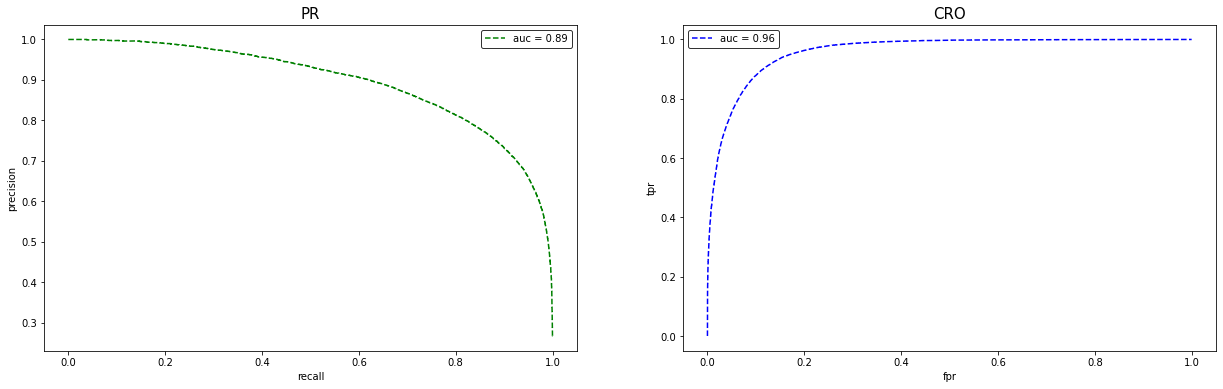

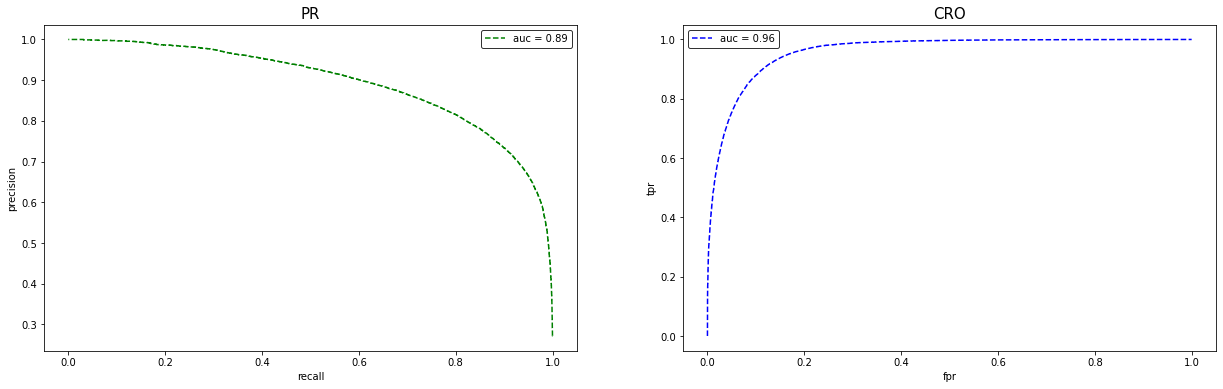

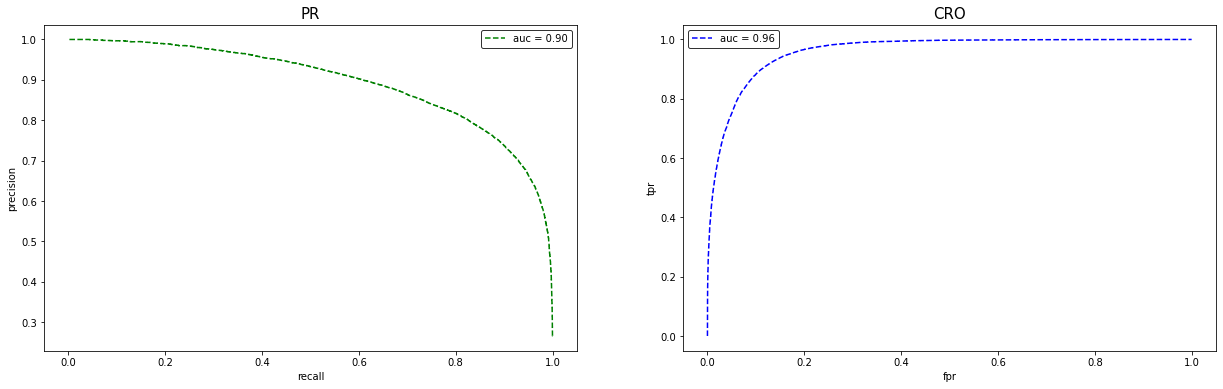

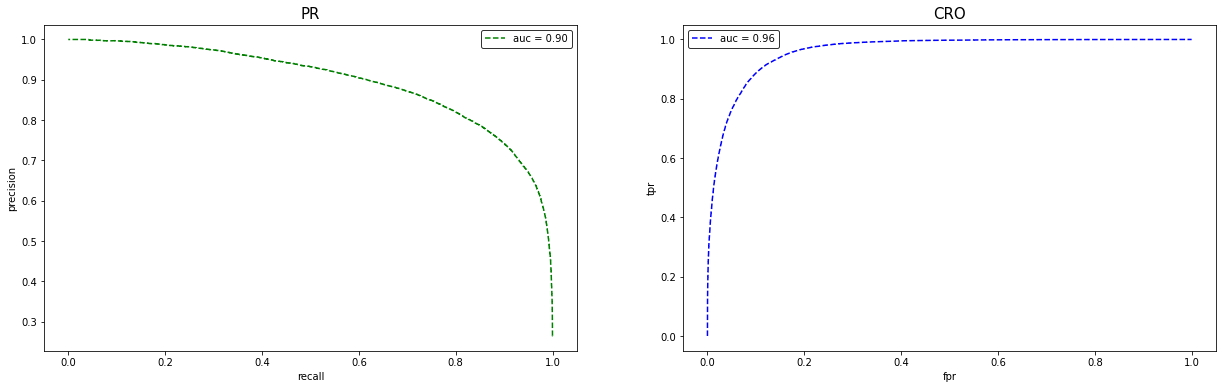

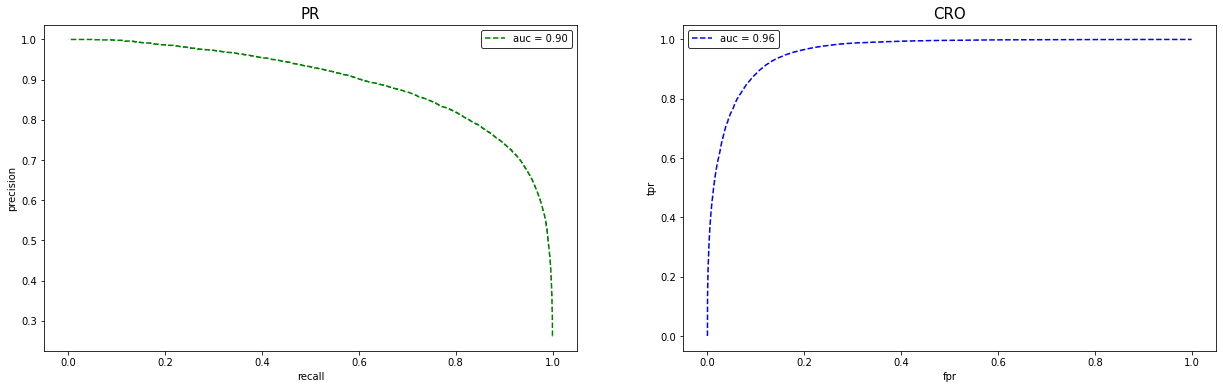

In [8]:
def train_model():
    model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        learning_tate=0.198857410046229,
        n_estimators=977,
        max_depth=20,
        min_child_weight=1.4225497311239266,
        min_child_samples=15,
        random_state=0
    )
    return model

x = 1
score_list = []
pred_list = []
kf = StratifiedKFold(n_splits=5)
for train_index, test_index in kf.split(df_train, df_train_label):
    print("train_index:", train_index[:3], "test_index:", test_index[:3])
    x_train = df_train.iloc[train_index]
    y_train = df_train_label.iloc[train_index, 0]
    x_val = df_train.iloc[test_index]
    y_val = df_train_label.iloc[test_index,0]
    

    
    model = train_model()
    
    eval_set =[(x_val, y_val)]
    eval_metric=[lgb_amex_metric]
    callbacks = []
    callbacks.append(lgb.early_stopping(stopping_rounds=10))
    callbacks.append(lgb.log_evaluation(100))
    model.fit(
        x_train, y_train,
        eval_set=eval_set,
        eval_metric=eval_metric,
        callbacks=callbacks
    )
    
    y_pred = model.predict_proba(x_val, raw_score=True)
    score = amex_metric(y_val, y_pred)
        
    score_list.append(score) 
    print(score_list)
    
    pred_list.append(model.predict_proba(df_test, raw_score=True))
    
    print(f"loop {x} >>> amex_metric:{score}============================================")
    curve_creater(model, y_val, x_val)
    x += 1
    

import statistics
print(statistics.mean(score_list))
print(np.mean(score_list))
    

## Create Submission

In [10]:
y_pred_3 = np.mean(pred_list, axis=0)

In [11]:
sub = pd.DataFrame({
    "customer_ID": df_test.index,
    "prediction":y_pred_3
})
sub.to_csv('submission.csv', index=False)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='amex'>

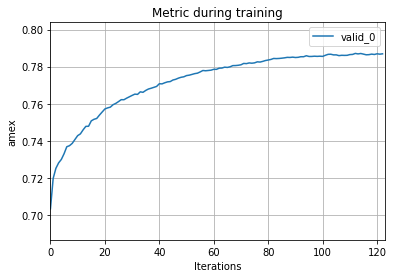

In [12]:
lgb.plot_metric(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

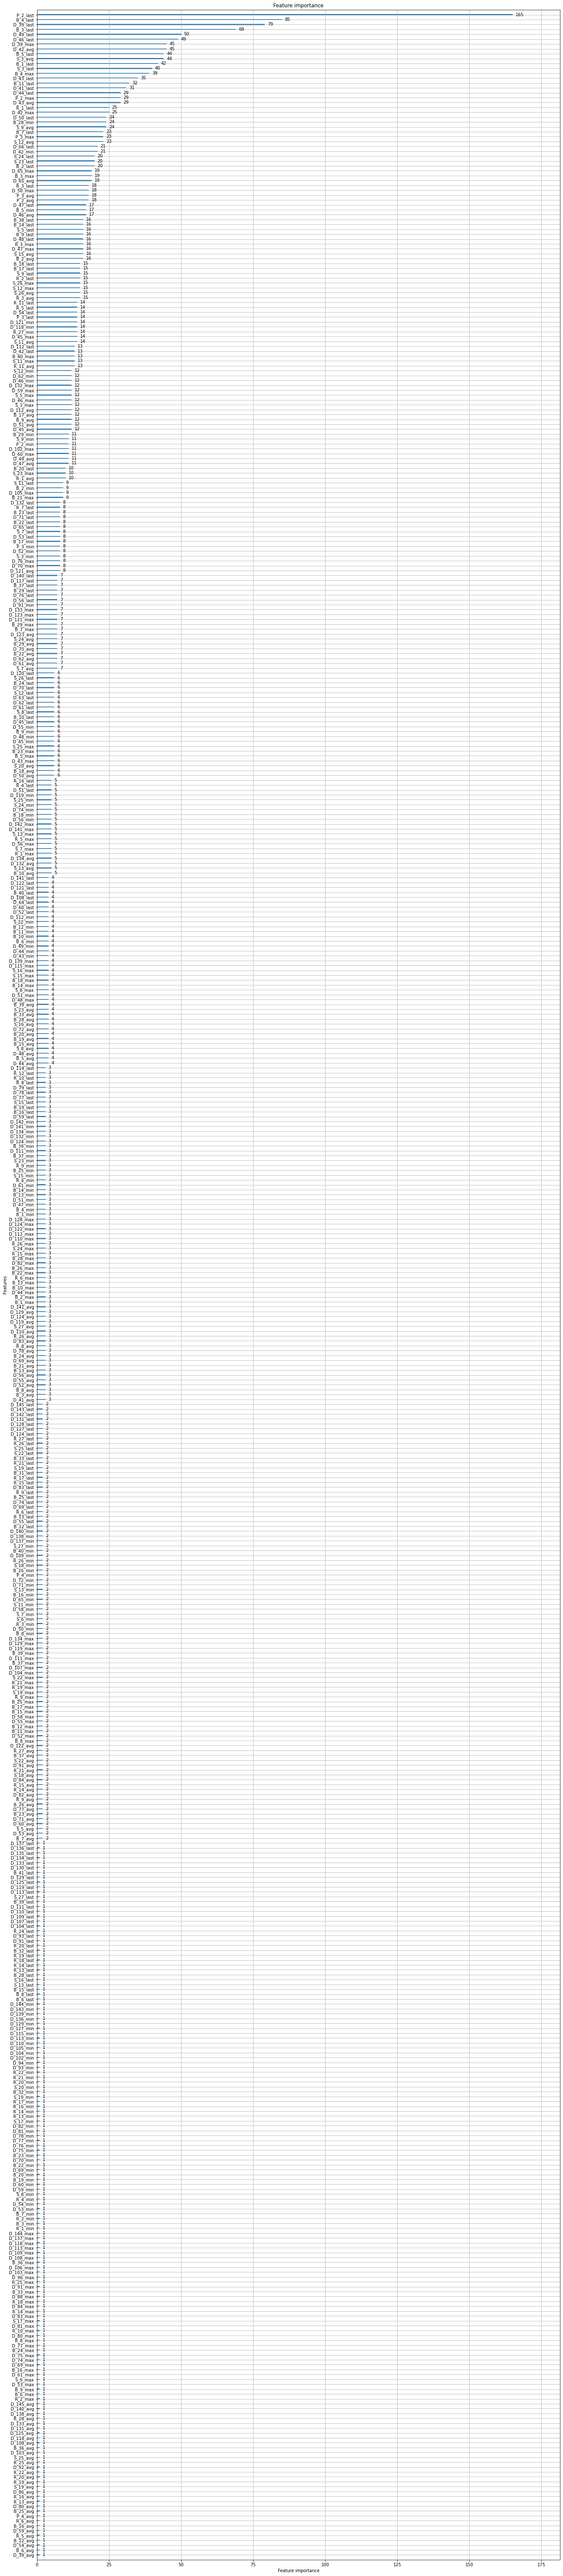

In [13]:
lgb.plot_importance(model, figsize=(22,110))